In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

## Data

In [2]:
TS = pd.read_excel("./Project 2_2022.xlsx", sheet_name="Data")
TS.Date = TS.Date.apply(pd.Timestamp)
TS = TS.set_index("Date")

## Anomalies

Описание этого говна через квантильный коридор

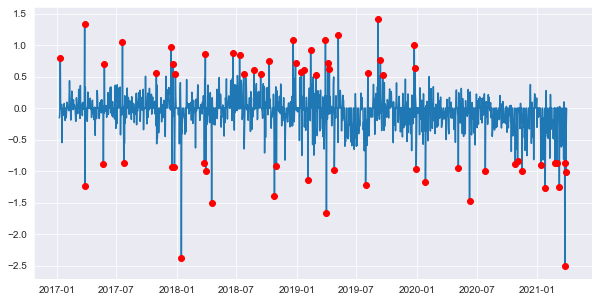

In [148]:
from modules.anomaly import detect_anomalies

anomaly_indexes = detect_anomalies(TS.Balance, visualize=True)

## Feature generation

In [124]:
from modules.feature_generation import generate_features

X, y = generate_features(TS[["Balance"]])

Feature Extraction: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


## Feature selection

In [65]:
from modules.feature_selection import select_features, test_stability

selected_features = select_features(X, y)
stability = test_stability(X, y, n_iterations=15)

In [70]:
stability

{'OLS recursive': 0.02118500056644379,
 'correlation': 0.5078696519618708,
 'mutual_info': 0.006722689075630228,
 'random_forest': 0.6265487354132706,
 'lasso l1': -0.0004631773969430153,
 'ensemble': 0.062240671682027515}

## Modeling

In [125]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [158]:
anomaly_indexes = anomaly_indexes[anomaly_indexes.isin(X.index)]
X_ = X.drop(anomaly_indexes)
y_ = y.drop(anomaly_indexes)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

model = XGBRegressor(n_estimators=50, random_state=42, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [163]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, model.predict(X_test))

0.20793988340594718

### train

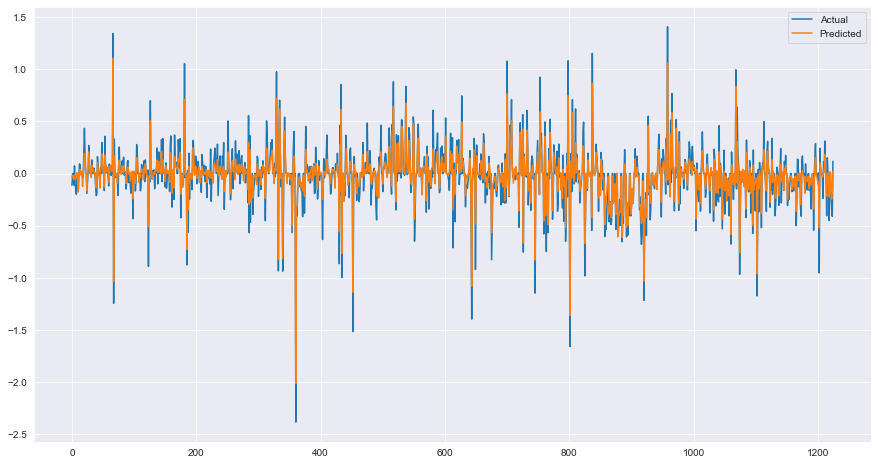

In [138]:
plt.figure(figsize=(15, 8))
plt.plot(y_train.values, label="Actual")
plt.plot(model.predict(X_train), label="Predicted")
plt.legend()

### test

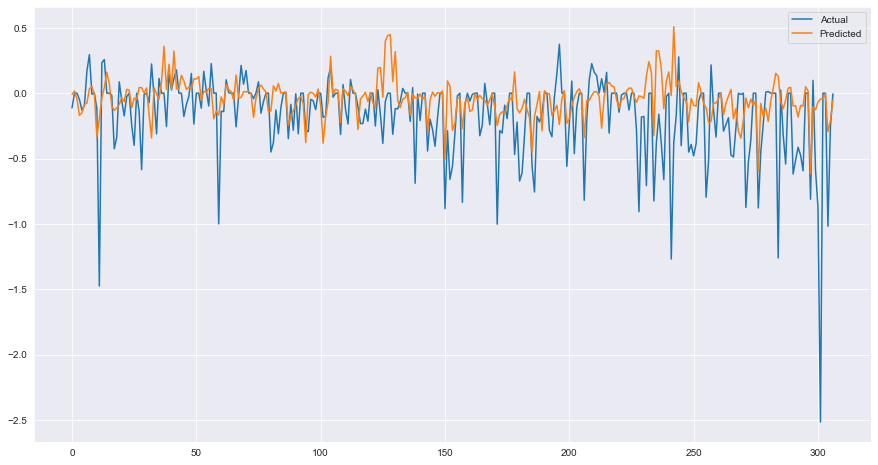

In [165]:
plt.figure(figsize=(15, 8))
plt.plot(TS.Balance[-X_test.shape[0]:].values, label="Actual")
plt.plot(model.predict(X_test), label="Predicted")
plt.legend()